In [ ]:
import torch
from transformers import pipeline
import fiftyone as fo
import boto3
import os

import numpy as np
from tqdm import tqdm 
from PIL import Image
import pandas as pd

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt



# Load the fiftyone dataset and its images

In [4]:
ds = fo.Dataset.from_dir('data/metadata', fo.types.FiftyOneDataset)
for sample in tqdm(ds): 
    file_id = sample.filepath.split('/')[-1]
    if not os.path.exists(f'data/samples/{file_id}'):
        boto3.client('s3').download_file('reversefashion-images', f"s/{file_id}", f'../data/samples/{file_id}')

Importing samples...
 100% |███████████████| 2223/2223 [44.1ms elapsed, 0s remaining, 50.4K samples/s]   
Migrating dataset '2025.11.11.05.18.13.081275' to v1.10.0


100%|██████████| 600/600 [00:00<00:00, 2324.27it/s]


In [5]:
from utils import load_Siglip2, apply_model_on_ds, load_Siglip, Load_Dino3
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Evaluate Gender of Jeans

In [ ]:
def save_df(df_all, translate, checkpoints): 

    df_all['pred_processed'] = df_all['pred'].apply(lambda x: translate.get(x, x))  
    df_all['pred_correct'] = df_all['label'] == df_all['pred_processed']

    grouped_tables = [
        df_all[df_all["checkpoint"] == checkpoint].groupby(['label', 'pred_processed']).size().unstack(fill_value=0)
        for checkpoint in checkpoints
    ]
    # Calculate accuracy for each checkpoint
    def get_accuracy(df, checkpoint):
        df_ckpt = df[df["checkpoint"] == checkpoint]
        if "pred_correct" in df_ckpt.columns:
            return df_ckpt["pred_correct"].mean()
        
    accuracies = [get_accuracy(df_all, checkpoint) for checkpoint in checkpoints]

    # Set up the 3x2 grid
    fig, axes = plt.subplots(2, 3, figsize=(16, 6))
    axes = axes.flatten()

    for idx, (checkpoint, table, acc) in enumerate(zip(checkpoints, grouped_tables, accuracies)):
        ax = axes[idx]
        ax.axis('off')
        tbl = ax.table(
            cellText=table.values,
            rowLabels=table.index,
            colLabels=table.columns,
            loc='center',
            cellLoc='center'
        )
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(12)
        tbl.scale(1.2, 1.2)
        ax.set_title(f"{checkpoint}\nAccuracy: {acc:.2%}", fontsize=14, pad=20)

    # Hide any unused subplots
    for j in range(len(checkpoints), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(f"plots/{'_'.join(candidate_labels)}.png", dpi=200)
    plt.show()



def calc_labels_suggestion(candidate_labels, category, checkpoints):

    dfs = []

    for checkpoint in checkpoints:
        print(f"Evaluating checkpoint: {checkpoint}")
        # Test Siglip2
        pipeline = load_Siglip2(checkpoint)
        df = apply_model_on_ds(
            ds_temp,
            pipeline_instance=pipeline,
            target_field=category,
            candidate_labels=candidate_labels,
        )
        del pipeline
        torch.cuda.empty_cache()
        df["checkpoint"] = checkpoint

        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

Evaluating checkpoint: google/siglip2-large-patch16-256


Device set to use cuda
100%|██████████| 134/134 [00:05<00:00, 24.27it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


Device set to use cuda
100%|██████████| 134/134 [00:02<00:00, 54.92it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:09<00:00, 13.73it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:04<00:00, 27.53it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:07<00:00, 17.04it/s]


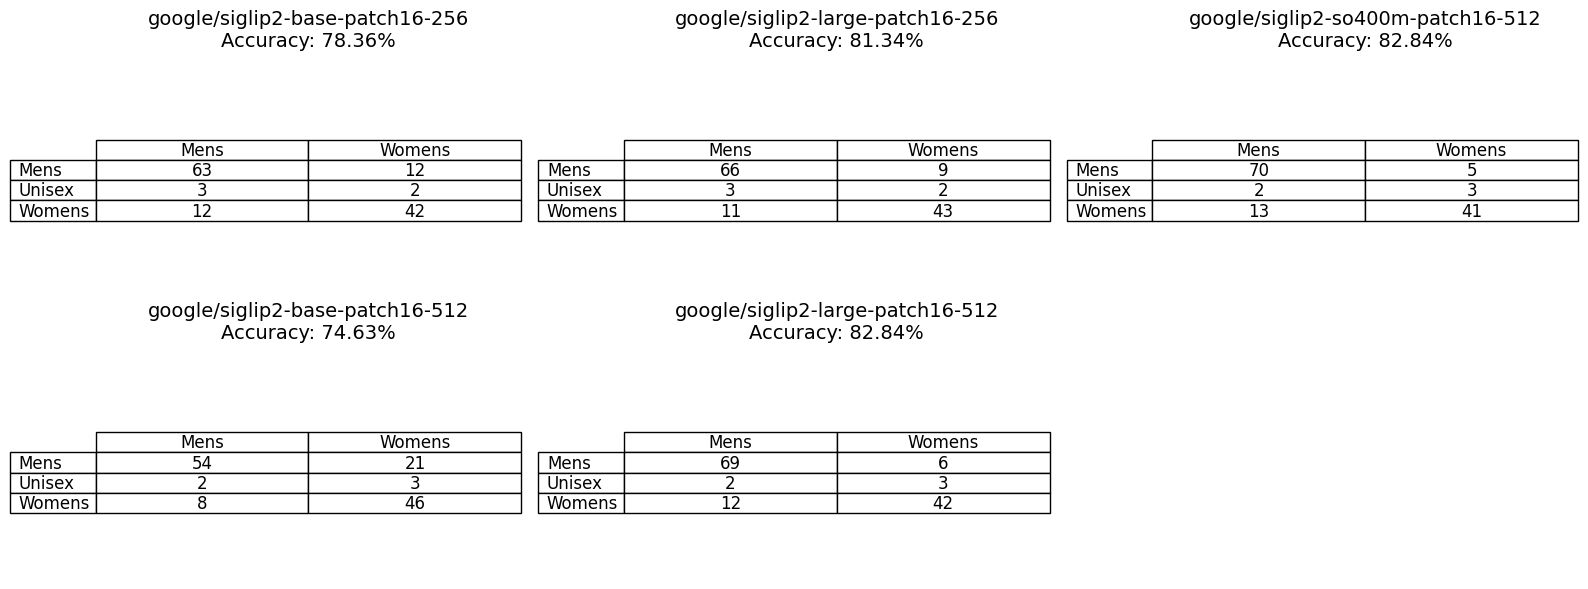

Evaluating checkpoint: google/siglip2-large-patch16-256


Device set to use cuda
100%|██████████| 134/134 [00:03<00:00, 41.52it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


Device set to use cuda
100%|██████████| 134/134 [00:02<00:00, 53.03it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:09<00:00, 13.41it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:04<00:00, 31.19it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:08<00:00, 16.59it/s]


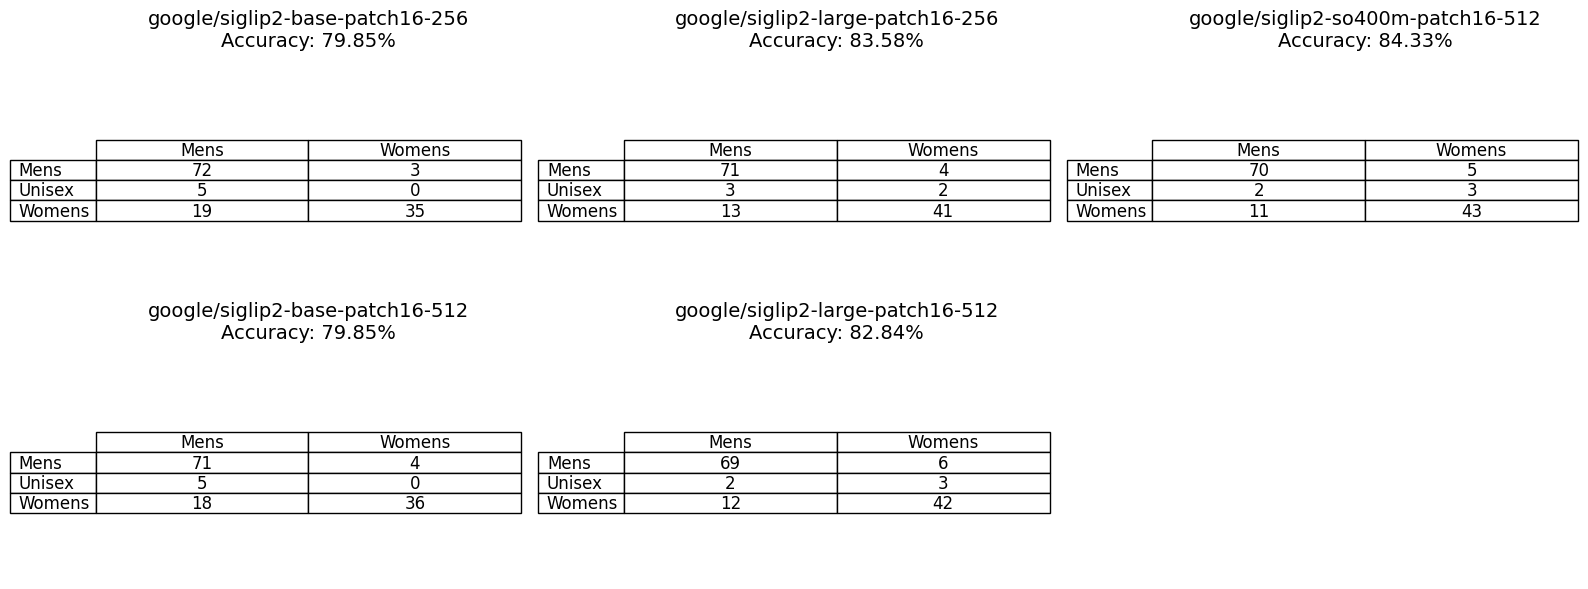

Evaluating checkpoint: google/siglip2-large-patch16-256


Device set to use cuda
100%|██████████| 134/134 [00:03<00:00, 37.26it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


Device set to use cuda
100%|██████████| 134/134 [00:03<00:00, 39.91it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:10<00:00, 13.15it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:04<00:00, 27.01it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:08<00:00, 16.54it/s]


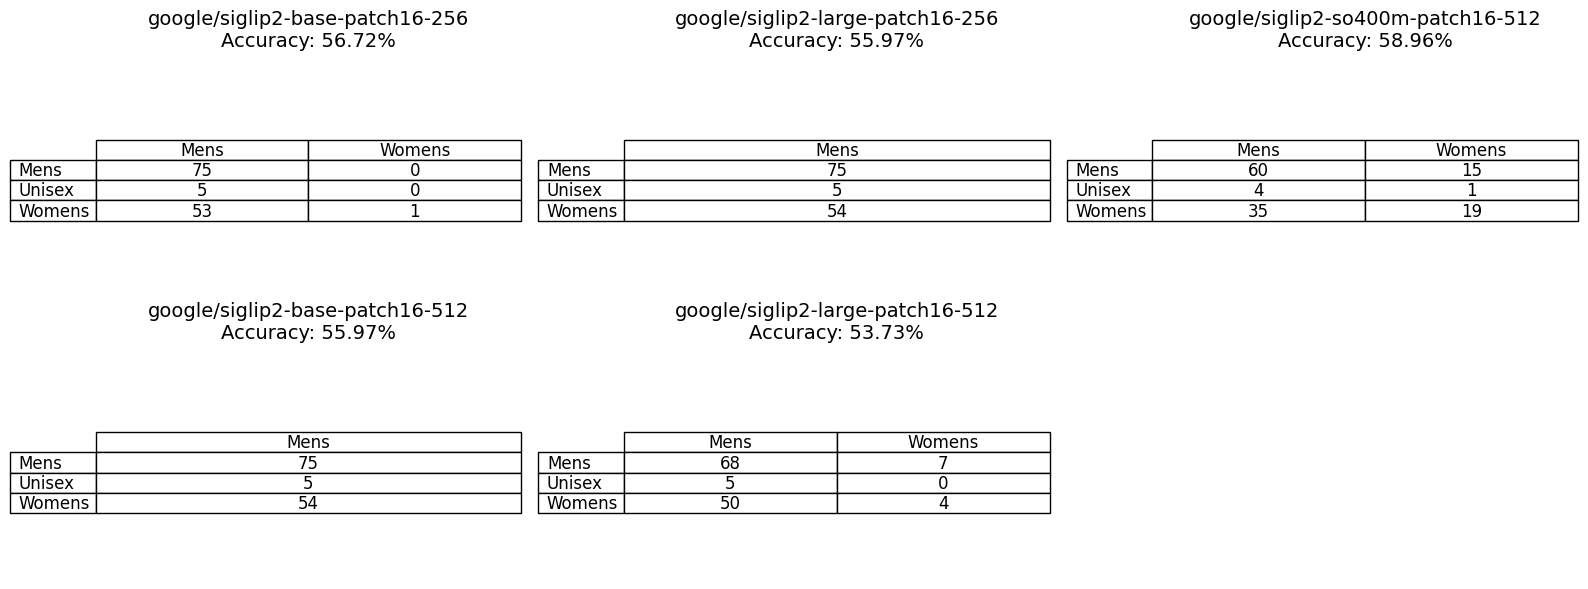

Evaluating checkpoint: google/siglip2-large-patch16-256


Device set to use cuda
100%|██████████| 134/134 [00:04<00:00, 32.49it/s]


Evaluating checkpoint: google/siglip2-base-patch16-256


Device set to use cuda
100%|██████████| 134/134 [00:02<00:00, 53.10it/s]


Evaluating checkpoint: google/siglip2-so400m-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:10<00:00, 12.25it/s]


Evaluating checkpoint: google/siglip2-base-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:05<00:00, 24.46it/s]


Evaluating checkpoint: google/siglip2-large-patch16-512


Device set to use cuda
100%|██████████| 134/134 [00:08<00:00, 15.98it/s]


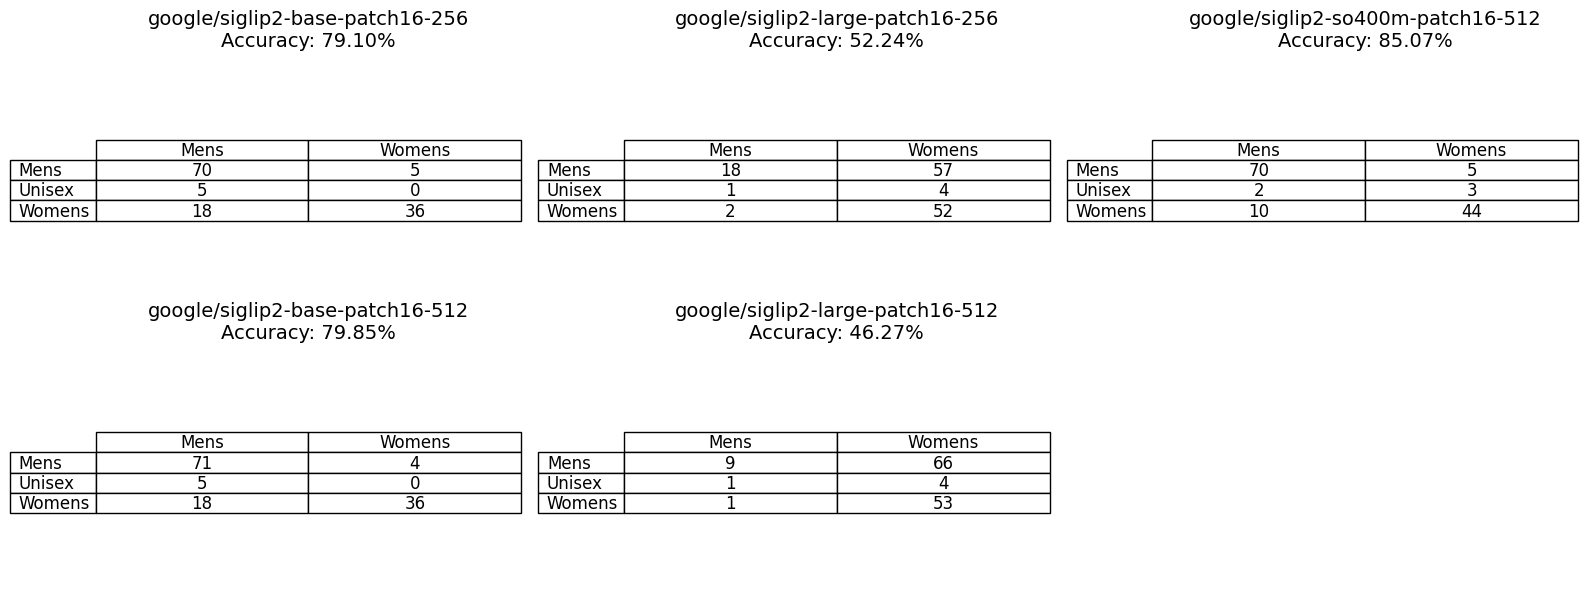

In [ ]:
# ds_temp = ds.match(fo.ViewField("Category three").contains(['Shirts', 'Tops & Blouses']))
# candidate_labels = ['a shirt with breast pockets', 'a shirt', 'a blouse', 'a top']


ds_temp = ds.match(fo.ViewField("Category three").contains(['Jeans']))

candidate_labels_list = [
    ['male', 'female'],
    ['a male jeans', 'a female jeans'], 
    ['Men', 'Women'],
    ['a male jeans', 'a female jeans', 'a curvy cut jeans' ,'a jeans with small waist']]
category = "Category two"

translate = {
    'female': 'Womens',
    'male': 'Mens',
    'Women': 'Womens',
    'Men': 'Mens',
    'a male jeans': 'Mens',
    'a female jeans': 'Womens',
    'a curvy cut jeans': 'Womens',
    'a jeans with small waist': 'Womens',
}

checkpoints = [
    "google/siglip2-large-patch16-256",
    "google/siglip2-base-patch16-256",
    "google/siglip2-so400m-patch16-512", 
    "google/siglip2-base-patch16-512",
    "google/siglip2-large-patch16-512"
]

for candidate_labels in candidate_labels_list:
    df_all = calc_labels_suggestion(candidate_labels, category, checkpoints)
    save_df(df_all, translate, checkpoints)

In [2]:
# temp = df[df["model_type"] == 'siglip']
# temp = temp[temp["label"] == 'Womens']
# temp = temp[temp["pred"] == 'a shirt with breast pockets']

# for file_id in temp['file_id'].values:
#     img = Image.open(f"data/samples/{file_id}")
#     display(img)